# Εργασία 1 (Τεχνικές Εξόρυξης Δεδομένων)
## Data Mining: Assignment 1
***
### Μαρία Φριτζελά 1115201400218
***

## Ερώτημα 1ο: Ανάλυση Δεδομένων (Data exploration)

This is going to be the place we write our imports:

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import folium
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from nltk import BigramCollocationFinder, wordpunct_tokenize
from nltk.collocations import BigramAssocMeasures
sns.set_style('whitegrid')

Creating lists of the column names that will be extracted
from the "listings.csv", "listings0.csv" files for each month:

In [2]:
# list of columns needed from listings0 file, as specified from assignment
columns0 = ['id','name','neighbourhood','latitude',
            'longitude','room_type', 'price', 'minimum_nights','number_of_reviews',
            'last_review', 'availability_365']
# list of the columns needed, as specified from assignment
columns = ["id", "zipcode", "transit", "bedrooms", "beds", "review_scores_rating",
           "number_of_reviews", "neighbourhood", "name", "latitude",
           "longitude", "last_review", "instant_bookable", "host_since", "host_response_rate",
           "host_identity_verified", "host_has_profile_pic", "first_review", "description",
           "city", "cancellation_policy", "bed_type", "bathrooms", "accommodates", "amenities",
           "room_type", "property_type", "price", "availability_365", "minimum_nights"]

Read csv files as Pandas DataFrames:

In [3]:
# GeoJSON Data for Athens. Needed for choropleth maps
ath_geo = 'data/april/neighbourhoods.geojson'

# Listings0
# index_col = Column(s) to use as the row labels of the DataFrame
mar_listings0 = pd.read_csv("data/march/listings0.csv", index_col='id', usecols=columns0)
apr_listings0 = pd.read_csv("data/april/listings0.csv", index_col='id', usecols=columns0)
feb_listings0 = pd.read_csv("data/february/listings0.csv", index_col='id', usecols=columns0)
# Listings
# index_col = Column(s) to use as the row labels of the DataFrame
mar_listings = pd.read_csv("data/march/listings.csv", index_col='id', usecols=columns)
apr_listings = pd.read_csv("data/april/listings.csv", index_col='id', usecols=columns)
feb_listings = pd.read_csv("data/february/listings.csv", index_col='id', usecols=columns)

Filling in the missing data:<br/>
<sub>(Modify listings DataFrame updating the values from listings0 for each month)<sub/>

In [4]:
# Update data of listings file from listings0 for each month (in place - not just NaN)
mar_listings.update(mar_listings0)
apr_listings.update(apr_listings0)
feb_listings.update(feb_listings0)

Concatenate data from the three months using a multi-level index:

In [5]:
# creating a multiIndex
traindf = pd.concat([feb_listings, mar_listings, apr_listings], keys=['feb', 'mar', 'apr'])
# Name index
traindf.index.names = ['month','id']
# remove dollar sign from price column for easier processing
traindf['price'].replace('[\$,]', '', regex=True, inplace=True)
# convert column to floats
traindf['price'] = traindf['price'].astype(float)

Demonstrating use of the multi-level index:

In [6]:
traindf.loc[('feb', 10595)]

name                                    96m2, 3BR, 2BA, Metro, WI-FI etc...
description               Athens Furnished Apartment No6 is 3-bedroom ap...
transit                   Note: 5-day ticket for all the public transpor...
host_since                                                       2009-09-08
host_response_rate                                                     100%
host_has_profile_pic                                                      t
host_identity_verified                                                    t
neighbourhood                                                   ΑΜΠΕΛΟΚΗΠΟΙ
city                                                                 Athens
zipcode                                                               11526
latitude                                                            37.9889
longitude                                                           23.7643
property_type                                                     Apartment
room_type   

## Ερωτήσεις (Questions)

### 1.1​ Ποιός είναι ο πιο συχνός τύπος  room_type για τα δεδομένα σας;<br/>
**1.1 What's the most common room_type in the data?**

Room type appearing more often in the data:

In [7]:
traindf['room_type'].mode()

0    Entire home/apt
dtype: object

All room types frequency per month:

In [8]:
traindf.groupby('month')['room_type'].value_counts()

month  room_type      
feb    Entire home/apt    8048
       Private room       1013
       Shared room          39
mar    Entire home/apt    8207
       Private room       1106
       Shared room          48
apr    Entire home/apt    8510
       Private room       1104
       Shared room          47
Name: room_type, dtype: int64

Presenting the above data in a bar graph:

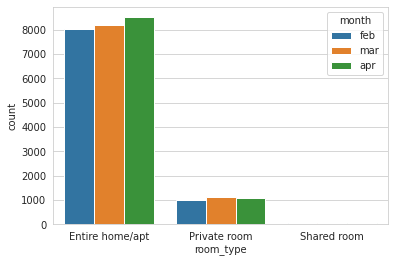

In [9]:
sns.countplot(x="room_type", hue='month', data=traindf.reset_index(level='month'))

### 1.2​ Φτιάξτε γράφημα ή γραφήματα που δείχνουν την πορεία των τιμών για το διάστημα των 3 μηνών<br/>
**1.2 Create a graph showing the price evolution in the duration of 3 months**

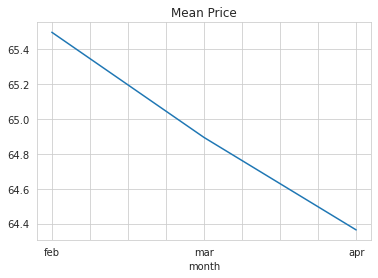

In [10]:
traindf['price'].mean(level=0).plot(title="Mean Price", kind='line')

### 1.3​ Ποιές είναι οι 5 πρώτες γειτονιές με τις περισσότερες κριτικές;<br/>
**1.3 Which are the top 5 most reviewed neighbourhoods?**

In [11]:
# Get the data for the month of April (most recent)
# group by neighbourhood and sum up only keeping the number_of_reviews column
# sort the values in ascending order and keep the first 5
traindf.loc['apr'].groupby('neighbourhood')['number_of_reviews'].sum().sort_values(ascending=False).iloc[:5]

neighbourhood
ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ              56950
ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ                 30549
ΝΕΟΣ ΚΟΣΜΟΣ                         23428
ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ            20570
ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ    16627
Name: number_of_reviews, dtype: int64

Plotting the number of reviews per neighbourhood in the month of April:

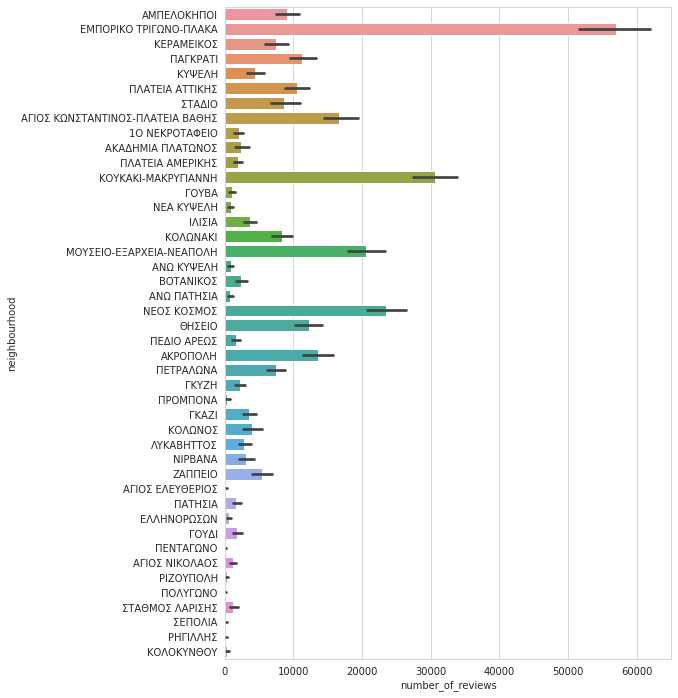

In [12]:
plt.figure(figsize=(8,12))
sns.barplot(x="number_of_reviews", y="neighbourhood",
            data=traindf.loc['apr'], estimator=sum)

Number of reviews per neighbourhood shown in a folium Choropleth map: (April)

In [13]:
# Initialize the map:
m13 = folium.Map(location=[37.983810, 23.727539], zoom_start=14)

# Add the color for the chloropleth:
folium.Choropleth(
 geo_data=ath_geo,
 name='choropleth',
 data=traindf.loc['apr'].groupby('neighbourhood')['number_of_reviews'].sum().sort_values(ascending=False),
 columns=['neighbourhood', 'number_of_reviews'],
 key_on='properties.neighbourhood',
 fill_color='YlGnBu',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Number of reviews'
).add_to(m13)

# Save to html
m13.save('13Q_Most_Reviewed_Neighbourhods.html')

m13

Plotting the number of reviews per neighbourhood and per month

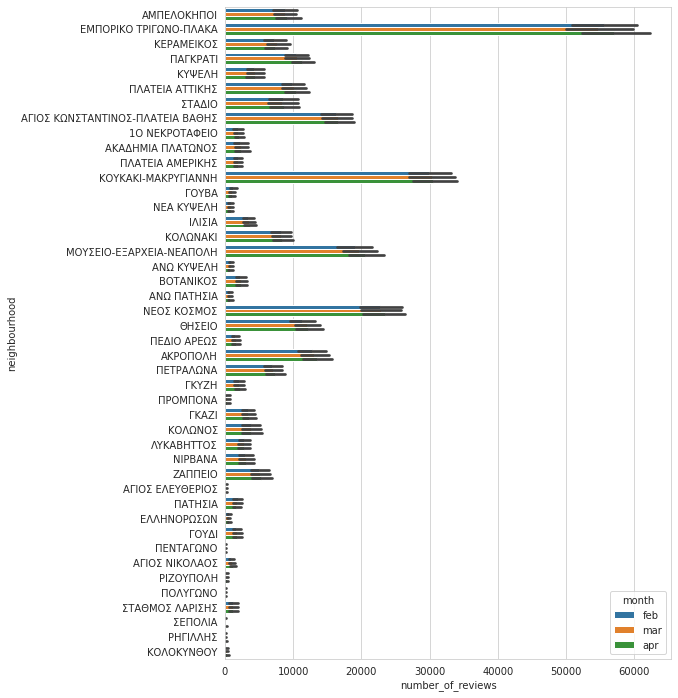

In [14]:
plt.figure(figsize=(8,12))
sns.barplot(x="number_of_reviews", y="neighbourhood", hue='month',
            data=traindf.reset_index(level=0), estimator=sum)

### 1.4 Ποιά είναι η γειτονιά με τις περισσότερες καταχωρήσεις ακινήτων;<br/>
**1.4 Which is the neighbourhood with the most listed properties?**

Find neighbourhood which appears most frequently in our data for the month of April: (most recent)

In [15]:
traindf.loc['apr']['neighbourhood'].mode()

0    ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ
dtype: object

Listings per neighbourhood in a pie chart (April):

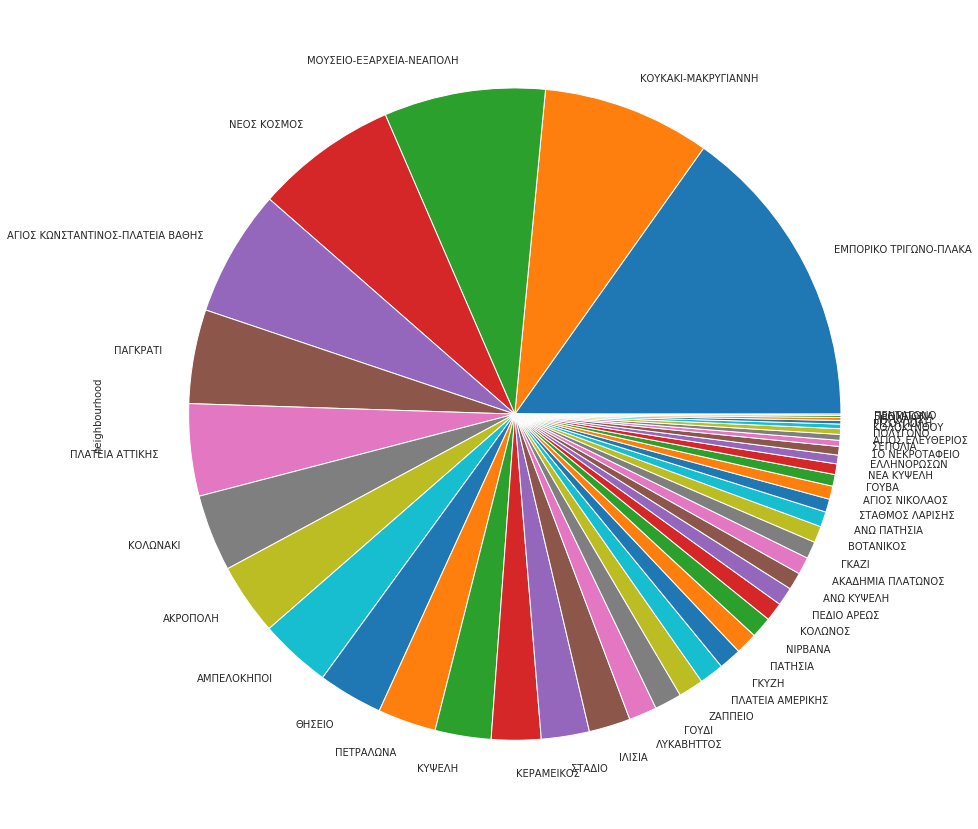

In [16]:
traindf.loc['apr']['neighbourhood'].value_counts().plot.pie(figsize=(15, 15))

Top 10 neighbourhoods with the most listings shown in a bar graph (April):

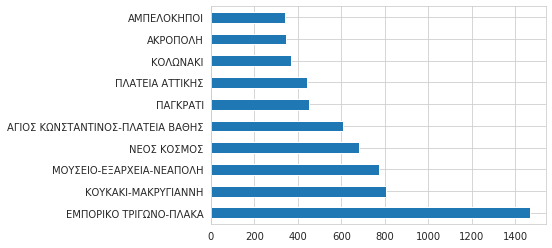

In [17]:
traindf.loc['apr']['neighbourhood'].value_counts()[:10].plot(kind='barh')

### 1.5​ Πόσες είναι οι καταχωρήσεις ανά γειτονιά και ανά μήνα;<br/>
**1.5 How many listings are there per neighbourhood and per month?**

In [18]:
# use size instead of count because we want to include rows with missing fields
traindf.groupby(['month', 'neighbourhood']).size()

month  neighbourhood                   
feb    1Ο ΝΕΚΡΟΤΑΦΕΙΟ                       42
       ΑΓΙΟΣ ΕΛΕΥΘΕΡΙΟΣ                     32
       ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ    571
       ΑΓΙΟΣ ΝΙΚΟΛΑΟΣ                       54
       ΑΚΑΔΗΜΙΑ ΠΛΑΤΩΝΟΣ                    76
                                          ... 
apr    ΡΗΓΙΛΛΗΣ                             14
       ΡΙΖΟΥΠΟΛΗ                            17
       ΣΕΠΟΛΙΑ                              29
       ΣΤΑΔΙΟ                              230
       ΣΤΑΘΜΟΣ ΛΑΡΙΣΗΣ                      63
Length: 132, dtype: int64

Listings per neighbourhood in a folium choropleth map (for the month of April)

In [19]:
# Initialize the map:
m15 = folium.Map(location=[37.983810, 23.727539], zoom_start=14)

# Add the color for the chloropleth:
folium.Choropleth(
 geo_data=ath_geo,
 name='choropleth',
 data=traindf.loc['apr']['neighbourhood'].value_counts(),
 columns=['neighbourhood'],
 key_on='properties.neighbourhood',
 fill_color='YlOrRd',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Number of listings'
).add_to(m15)

# Save to html
m15.save('14Q_Most_Listed_Neighbourhods.html')

m15

### 1.6​ Σχεδιάστε το ιστόγραμμα της μεταβλητής neighbourhood<br/>
1.6 Design the histogram of the neighbourhood variable

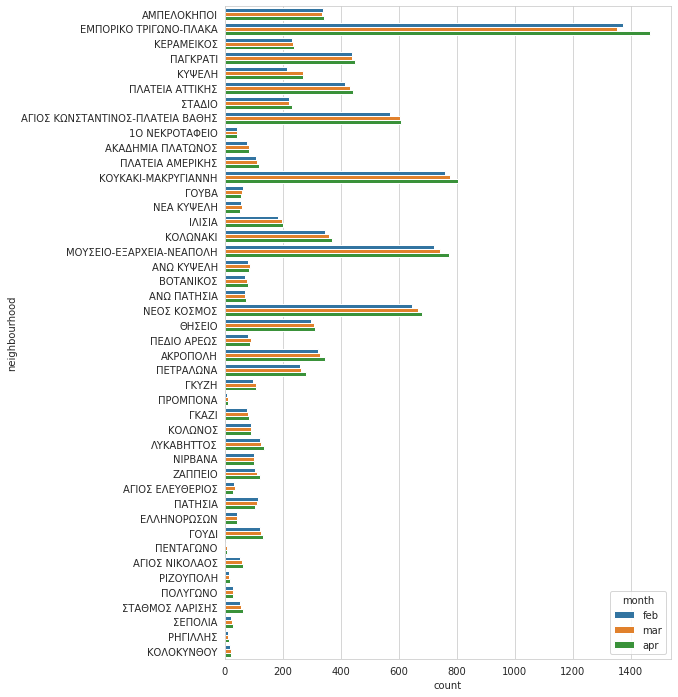

In [20]:
plt.figure(figsize=(8,12))
sns.countplot(y='neighbourhood', hue='month', data=traindf.reset_index(level=0))

### 1.7​ Ποιος είναι ο πιο συχνός τύπος δωματίου (room_type) σε κάθε γειτονιά;<br/>
**1.7 What's the most common room_type in each neighbourhood?**

Showing most common room type for each neighbourhood per month in a DataFrame:

In [21]:
# apply the pd.Series.mode function to each group
traindf.groupby(['neighbourhood', 'month'])['room_type'].agg(pd.Series.mode).to_frame()

room_type
neighbourhood    month                                    
1Ο ΝΕΚΡΟΤΑΦΕΙΟ   feb                       Entire home/apt
                 mar    0    Entire home/apt
dtype: object
                 apr    0    Entire home/apt
dtype: object
ΑΓΙΟΣ ΕΛΕΥΘΕΡΙΟΣ feb    0    Entire home/apt
dtype: object
                 mar    0    Entire home/apt
dtype: object
...                                                    ...
ΣΤΑΔΙΟ           mar    0    Entire home/apt
dtype: object
                 apr    0    Entire home/apt
dtype: object
ΣΤΑΘΜΟΣ ΛΑΡΙΣΗΣ  feb    0    Entire home/apt
dtype: object
                 mar    0    Entire home/apt
dtype: object
                 apr    0    Entire home/apt
dtype: object

[132 rows x 1 columns]

Visualizing the room types per neighbourhood for only April:

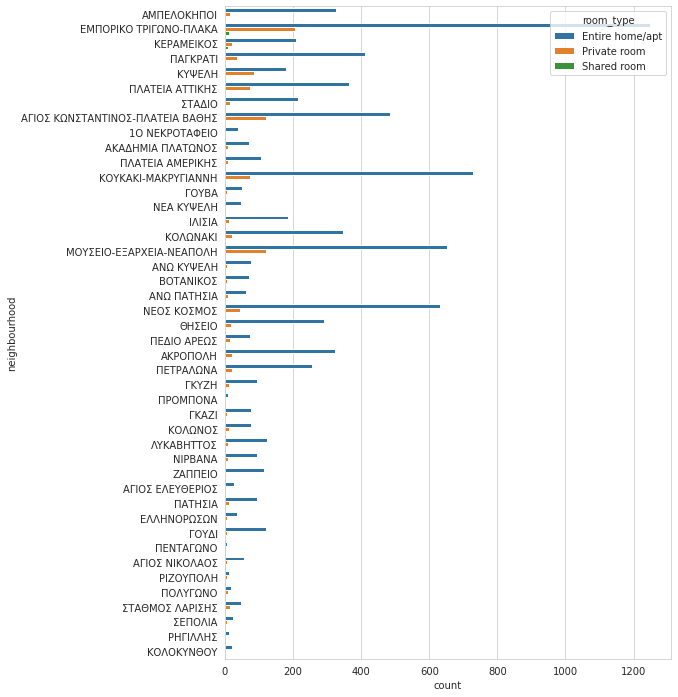

In [22]:
plt.figure(figsize=(8,12))
sns.countplot(y='neighbourhood', hue='room_type', data=traindf.loc['apr'])

Visualizing the room types per neighbourhood for each month:

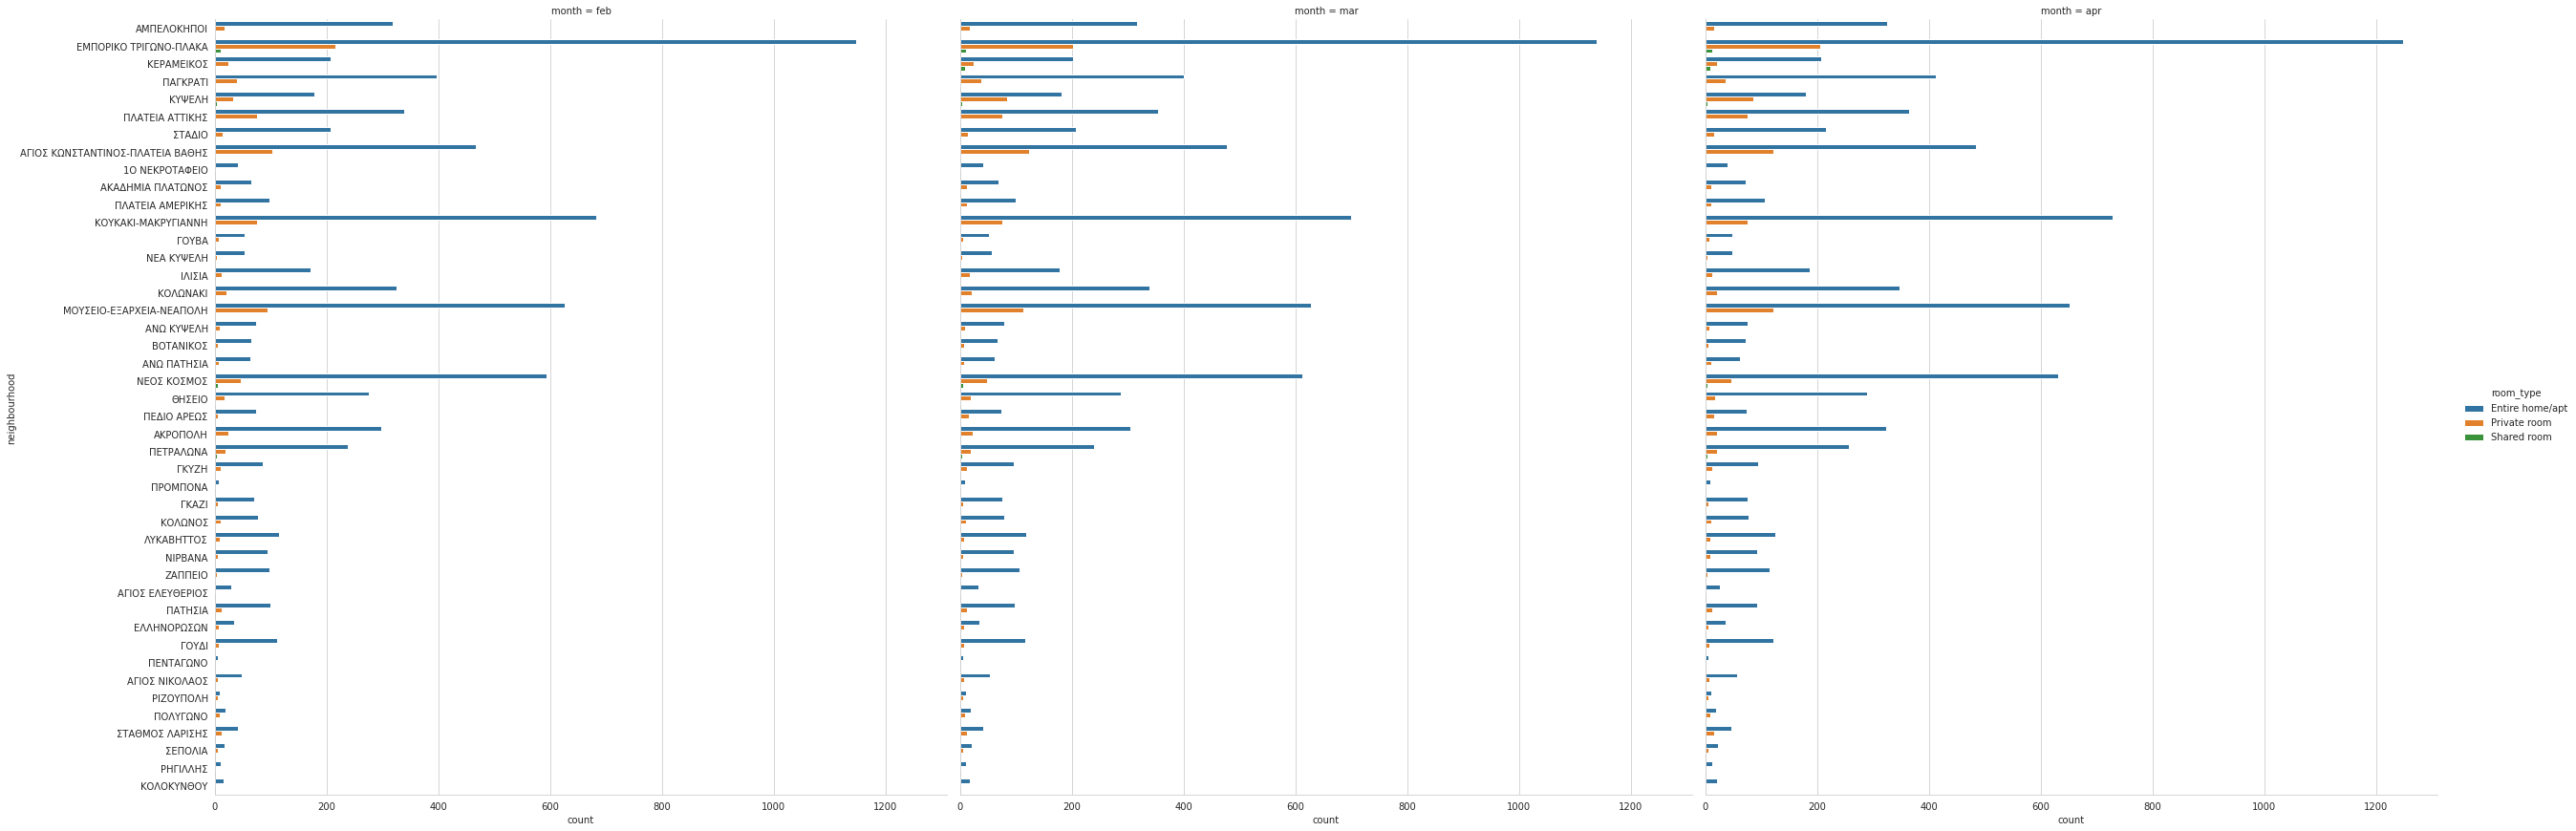

In [23]:
sns.catplot(y="neighbourhood", hue="room_type", col="month",
            data=traindf.reset_index(level=0), kind="count", height=12)

### 1.8​ Ποιός είναι ο πιο ακριβός τύπος δωματίου;<br/>
**1.8 What's the most expensive room_type?**

Average prices per room type for each month:

In [24]:
traindf.groupby(['month','room_type'])['price'].mean()

month  room_type      
feb    Entire home/apt    63.235959
       Private room       84.524186
       Shared room        38.076923
mar    Entire home/apt    63.308030
       Private room       78.050633
       Shared room        33.000000
apr    Entire home/apt    62.677673
       Private room       78.677536
       Shared room        33.425532
Name: price, dtype: float64

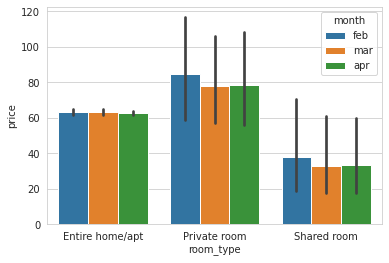

In [25]:
sns.barplot(x='room_type', y='price', hue='month', data=traindf.reset_index(level=0))

<h3>1.9 Χρησιμοποιήστε τη βιβλιοθήκη  Folium Map με τις στήλες latitude/longitude
και εμφανίστε σε ένα χάρτη για ένα μήνα της επιλογής σας τα ακίνητα
και στα popup στον χάρτη επιλέξτε όποια άλλη πληροφορία θέλετε να εμφανίζεται για το ακίνητο
(πχ bed_type, room_type, transit κτλ)</h3>

**1.9 Using the Folium Map library show a map (for a month of your choice)
with all the properties from you dataset.**

Chosen month: April

In [26]:
map19 = folium.Map(location=[37.983810, 23.727539], zoom_start=14)

#place = traindf.loc[('apr',10595)]
#lon = round(place['longitude'], 6)
#lat = round(place['latitude'], 6)
#folium.Marker([lat, lon], popup=place['name']).add_to(map)

# add marker one by one on the map
# use only first 1000 properties to not fill the map too much 
for i, place in traindf.loc['apr'][:1000].iterrows():
    folium.Marker([round(place['latitude'], 6),
                  round(place['longitude'], 6)],
                  popup=place['room_type']).add_to(map19)


In [27]:
#save map
map19.save('map19.html')

map19

### 1.10​ Φτιάξτε διαφορετικά wordclouds με τα δεδομένα από τη στήλη neighbourhood, transit, description, last_review.
**1.10 Create wordclouds using the data from columns: neighbourhood, transit, description, last_review.**

a) For the neighbourhood column:

In [28]:
#create wordcloud
wordcloud_neighbourhood = WordCloud(
    width = 800,
    height = 800,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(traindf['neighbourhood'].dropna().values))

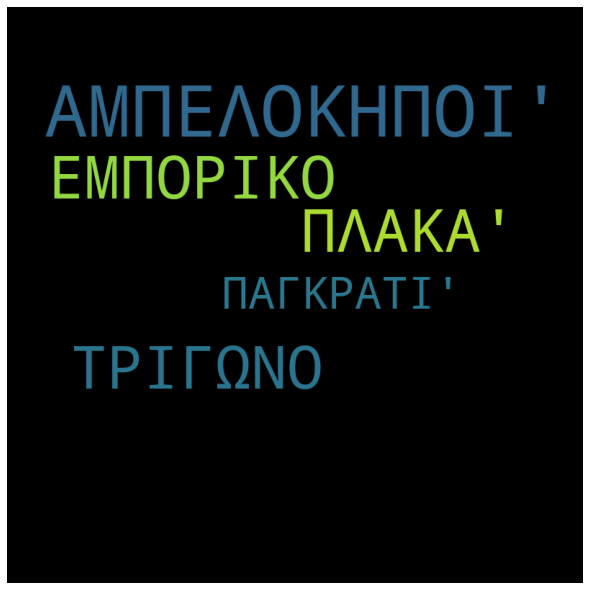

In [29]:
#show it
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_neighbourhood)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

b) For the transit column:

In [30]:
#create wordcloud
wordcloud_transit = WordCloud(
    width = 800,
    height = 800,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(traindf['transit'].dropna().values))

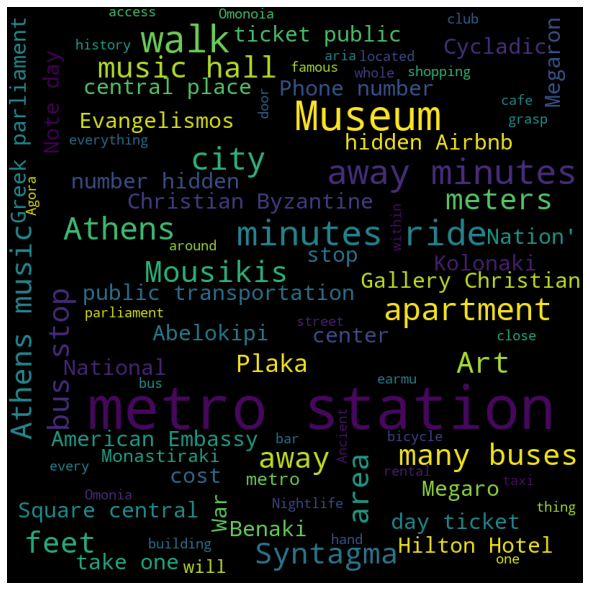

In [31]:
#show it
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_transit)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

c) For the description column

In [32]:
#create wordcloud
wordcloud_description = WordCloud(
    width = 800,
    height = 800,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(traindf['description'].dropna().values))

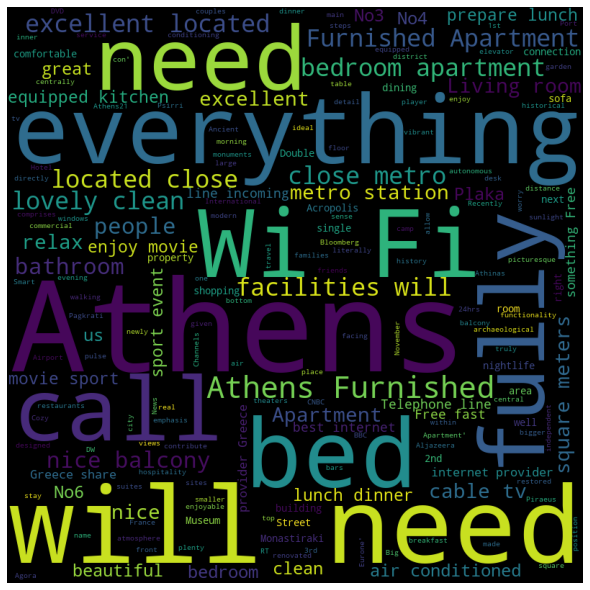

In [33]:
#show it
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_description)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

d) For the last_review column

We have to extract the reviews for each date from the last_review column

In [34]:
# Get all reviews from the three months in our csv
mar_reviewsdf = pd.read_csv("data/march/reviews.csv", index_col='listing_id', usecols=['listing_id','date', 'comments'])
apr_reviewsdf = pd.read_csv("data/april/reviews.csv", index_col='listing_id', usecols=['listing_id','date', 'comments'])
feb_reviewsdf = pd.read_csv("data/february/reviews.csv", index_col='listing_id', usecols=['listing_id','date', 'comments'])
# Combine them into one multi index dataframe
reviewsdf = pd.concat([feb_reviewsdf, mar_reviewsdf, apr_reviewsdf], keys=['feb', 'mar', 'apr'])
# Name index
reviewsdf.index.names = ['month','id']

Then we perform a join operation with our last_review column

In [35]:
lrdf = traindf['last_review'].dropna()
last_reviews_df = reviewsdf.join(lrdf, how='inner').sort_index(1)

In [36]:
#create wordcloud
wordcloud_review = WordCloud(
    width = 800,
    height = 800,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(last_reviews_df.loc[last_reviews_df['date'] == 
                                                            last_reviews_df['last_review']].values))

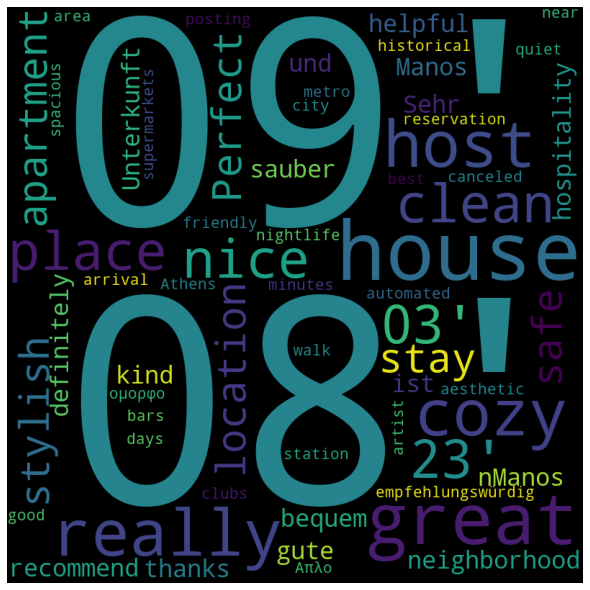

In [37]:
#show it
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_review)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### 1.11 Ποιά είναι η μέση τιμή ανά πλήθος επισκεπτών;

**1.11 Average price per people to accommodate**

In [38]:
traindf.groupby(['month','accommodates'])['price'].mean()

month  accommodates
feb    1                78.364706
       2                49.288462
       3                55.084411
       4                61.260134
       5                67.668689
       6                83.302618
       7                81.005376
       8               111.482890
       9                94.360656
       10              154.646154
       11              196.500000
       12              182.685714
       13              124.200000
       14              143.866667
       15              159.933333
       16              295.095238
       19              153.000000
       20              174.333333
       26              184.000000
mar    1                52.722222
       2                49.080435
       3                55.374810
       4                60.701441
       5                67.802158
       6                83.985816
       7                82.421875
       8               104.503704
       9               101.909091
       10              149.4

Presenting the above data with a bar graph:

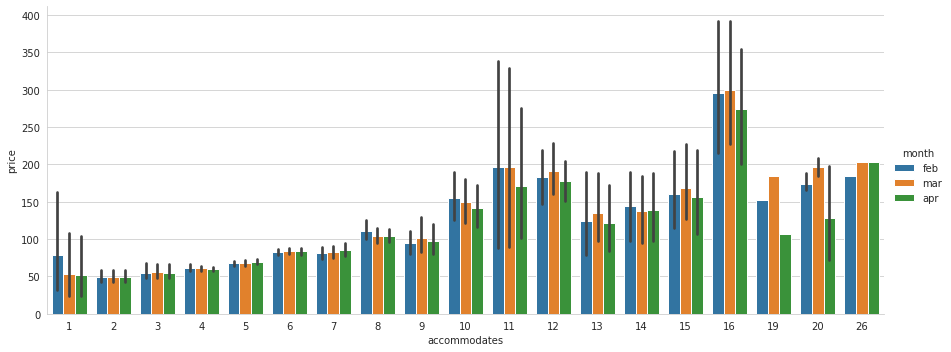

In [39]:
sns.catplot(x="accommodates", y="price", hue="month", data=traindf.reset_index(level=0),
            aspect=2.5, kind='bar')

### 1.12 Συνδέεται η τιμή με τις κριτικές;

**1.12 Does the price of the listing relate to the review score?**

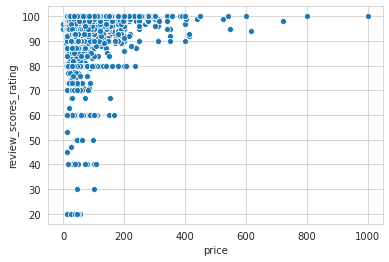

In [40]:
sns.scatterplot(x='price', y='review_scores_rating', data=traindf.loc['feb'])


It is evident that as the price of the listing gets higher (>200) the review score is higher (>80 percent rating)<br/>
This doesnt mean that one can't find highly rated listings (>70 percent) at a lower price (<200)

### Average price per neighbourhood

In [41]:
traindf.groupby(['month','neighbourhood'])['price'].mean()

month  neighbourhood                   
feb    1Ο ΝΕΚΡΟΤΑΦΕΙΟ                      58.071429
       ΑΓΙΟΣ ΕΛΕΥΘΕΡΙΟΣ                    52.656250
       ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ    58.653240
       ΑΓΙΟΣ ΝΙΚΟΛΑΟΣ                      37.148148
       ΑΚΑΔΗΜΙΑ ΠΛΑΤΩΝΟΣ                   46.065789
                                             ...    
apr    ΡΗΓΙΛΛΗΣ                            85.142857
       ΡΙΖΟΥΠΟΛΗ                           35.294118
       ΣΕΠΟΛΙΑ                             39.000000
       ΣΤΑΔΙΟ                              58.917391
       ΣΤΑΘΜΟΣ ΛΑΡΙΣΗΣ                     56.238095
Name: price, Length: 132, dtype: float64

Displaying Average Price per neighbourhood for April using a Folium Colorpleth map:

In [42]:
# Initialize the map:
mex = folium.Map(location=[37.983810, 23.727539], zoom_start=14)

# Add the color for the chloropleth:
folium.Choropleth(
 geo_data=ath_geo,
 name='choropleth',
 data=traindf.loc['apr'].groupby('neighbourhood')['price'].mean(),
 columns=['neighbourhood'],
 key_on='properties.neighbourhood',
 fill_color='BuGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Average Price'
).add_to(mex)

# Save to html
mex.save('Q_Avg_price_per_neighbourhood.html')

mex

## Ερώτημα 2: Recommendation system

In the previous section we created the following wordcloud from the description column of our data:

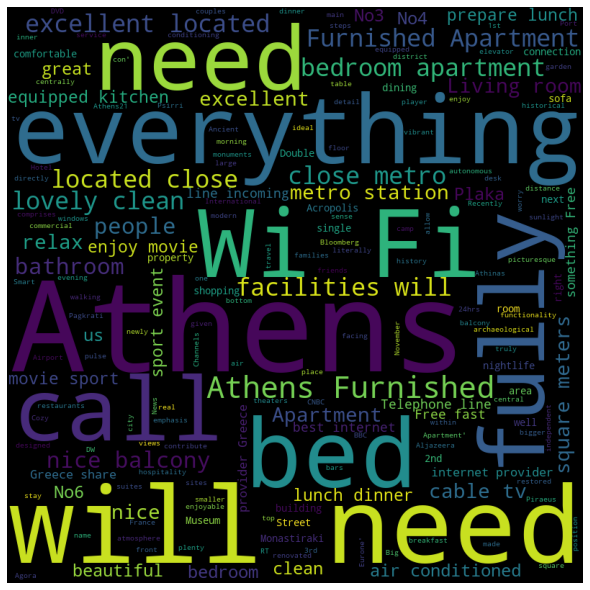

In [43]:
#show wordcloud_description
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_description)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

We will create a content-based recommendation system, calculating the similarity of listings using their name and description.

### 0. Preparing the data

Create a pandas Series by concatenating the name and description column of the traindf DataFrame:

In [44]:
descr = traindf[['name', 'description']].fillna(' ')\
        .apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [45]:
descr

month  id      
feb    10595       96m2, 3BR, 2BA, Metro, WI-FI etc... Athens Fur...
       10988       75m2, 2-br, metro, wi-fi, cable TV Athens Furn...
       10990       50m2, Metro, WI-FI, cableTV, more Athens Furni...
       10993       Studio, metro, cable tv, wi-fi, etc The Studio...
       10995       47m2, close to metro,cable TV,wi-fi AQA No2 is...
                                         ...                        
apr    33819692    Lysicrates Monument - Athens 33 "Athens 33" is...
       33820145    Bright and Stylish Exarchia apartment Newly re...
       33821757    Athens21 Athens 21 is centrally located right ...
       33821833    Tower of Winds "Athens 33" is a newly renovate...
       33822443    Beautiful and modern Pagkrati Apartment Beauti...
Length: 28122, dtype: object

Some listings kept the same description thoughout the three months. We use the following command to remove these duplicate rows.</br>

(rows with the same id and description)

In [46]:
descr = descr.reset_index().rename(columns={ 0: "descr"})\
            .drop_duplicates(subset=['id','descr'], keep='last').set_index('id')

In [47]:
descr

,month,descr
id,,
28186,feb,❤️Deluxe central loft near Acropolis❤️ ⭐️Don't...
85400,feb,Plaka area Close to Acropolis Museum Up to 3 ...
155654,feb,"Acropolis cosy apartment, Koukaki, wi-fi, AC ..."
250498,feb,Splendid spacious apt in great area This splen...
309315,feb,Center Athens:Cozy new apt-Plaka Brand New Ren...
...,...,...
33819692,apr,"Lysicrates Monument - Athens 33 ""Athens 33"" is..."
33820145,apr,Bright and Stylish Exarchia apartment Newly re...
33821757,apr,Athens21 Athens 21 is centrally located right ...


Then, concatenate the name/decriptions for the same listing on different months:<br/>
* Add a space before performing the sum to not connect words together accidentally<br/>
* **Make all the words lower case** to facilitate clean up, using `.lower`<br/>
* **Remove punctuation and special characters** using `re.sub` <br/>
* **Remove words:** "athens" followed by any (or none) digits, "greece", "etc", and "no" followed by a digit


In [48]:
descr = descr['descr'].sort_index()\
        .apply(lambda item: item+" ")\
        .sum(level='id')\
        .apply(lambda item: item.lower())\
        .apply(lambda item: re.sub('[^A-Za-z0-9 ]+', '', item))\
        .apply(lambda item: re.sub(r"\bathens\w*|\bgreece\w*|\bect|\bno\d+", "", item))

In [49]:
descr

id
10595       96m2 3br 2ba metro wifi etc  furnished apartme...
10988       75m2 2br metro wifi cable tv  furnished apartm...
10990       50m2 metro wifi cabletv more  furnished apartm...
10993       studio metro cable tv wifi etc the studio is a...
10995       47m2 close to metrocable tvwifi aqa  is 1bedro...
                                  ...                        
33819692    lysicrates monument   33  33 is a newly renova...
33820145    bright and stylish exarchia apartment newly re...
33821757      21 is centrally located right next to monast...
33821833    tower of winds  33 is a newly renovated buildi...
33822443    beautiful and modern pagkrati apartment beauti...
Name: descr, Length: 10385, dtype: object

Creating a wordcloud with the cleaned-up data:

In [50]:
#create wordcloud
wordcloud_descr_name = WordCloud(
    width = 800,
    height = 800,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(descr.values))

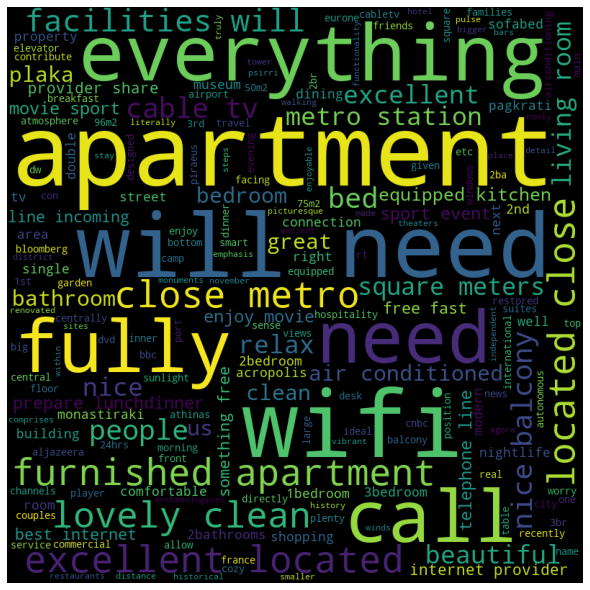

In [51]:
#show wordcloud_descr_name
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_descr_name)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### 1. TF -IDF Vector

In [52]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000,  stop_words='english')

In [53]:
tfidf = tfidf_vectorizer.fit_transform(descr.values)

In [54]:
tfidf.shape

(10385, 1000)

In [55]:
pd.DataFrame(tfidf[0:1].T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])\
.sort_values(by=["tfidf"],ascending=False)

,tfidf
need,0.328209
excellent,0.314852
clean,0.246267
bedroom single,0.241111
close metro,0.223637
...,...
equipment,0.000000
ermou,0.000000
espresso,0.000000
euros,0.000000


### 2. Cosine Similarity

We need to find the cosine distances of each one listing's tfidf vector and all the others. For each listing we need to compute the dot product of it's vector with all the others.<br/>
For the dot product we will use the linear kernel from `sklearn`

We need to slice row wise for each listing's vector.<br/>
So for the n-th listing's vector we need to use `tfidf[n:n+1]`

In [56]:
linear_kernel(tfidf[0:1], tfidf).flatten() #cosine similarities

array([1.        , 0.7542487 , 0.75623278, ..., 0.05521884, 0.07866723,
       0.05261795])

To find the id's of the related listings, we can use `argsort` to get the indices of the most similar vectors.<br/>

In [57]:
linear_kernel(tfidf[0:1], tfidf).flatten().argsort()

array([9111, 6561, 6549, ...,    2,    4,    0])

The most related listings have **highest** cosine similarity values, so we will use negative slicing to get them from the end of the sorted indices array.<br/> The first one is always the listing itself

_**Note:** these indices returned are not the listing id's, but the integer location of the listing in the series used as input when making the tfidf vector._

### Τα 100 πιο όμοια ακίνητα <br/>
**Top 100 Most Related Listings**

Create a dataframe keeping only the most recent data per listing id (will be used for printing information later)

In [58]:
printdf = traindf.reset_index().drop_duplicates(subset=['id'], keep='last').set_index('id').sort_index()

Compute cosine similarity of each listing with every other listing and save as a numpy array.<br/>
It's a square matrix where value of (0,2) is the similarity of listings positioned in locations 0 and 2.<br/>
Keep the upper triangle of the calculated square matrix (filling the rest with zeros). We do this to avoid duplicate results later, as (0,1) is the same as (1,0)

In [59]:
b = np.triu(np.array(linear_kernel(tfidf,tfidf)))

We also fill the diagonal with zeros as obviously the pairs (0,0), (1,1) are identical.

In [60]:
np.fill_diagonal(b, 0)
b.shape

(10385, 10385)

Create a function which will return the indexes of the k largest values of a matrix

In [61]:
def k_largest_index_argsort(a, k):
    idx = np.argsort(a.ravel())[:-k-1:-1]
    return np.column_stack(np.unravel_index(idx, a.shape))

In [62]:
locations = k_largest_index_argsort(b, k=100)

These locations returned are not the actual ids of the listings. They are the indices of the `descr.values` as given to create the tfidf vector.<br/> 
We will use the `descr.index` to discover their actual ids from their location

In [63]:
print("Top 100 Most similar Listings")
for loc1, loc2 in locations:
    id1 = descr.index[loc1]
    id2 = descr.index[loc2]
    print("---Listing with id: "+str(id1)+" and listing with id: "+str(id2))
    print(printdf.loc[id1]['name'])
    print(printdf.loc[id2]['name'])

Top 100 Most similar Listings
---Listing with id: 22074163 and listing with id: 22074541
Great Living #3
Great Living #1
---Listing with id: 32634089 and listing with id: 32649434
1 Room SleepEasy {2beds_4people}
2 Room SleepEasy       {2beds_3people}
---Listing with id: 32881267 and listing with id: 32881617
Wheat Room 2
Wheat Room 3
---Listing with id: 22173279 and listing with id: 24214247
Penthouse Suite in heart of Athens, stunning views
Penthouse Suite in heart of Athens, stunning views
---Listing with id: 32649918 and listing with id: 32650458
3 Room SleepEasy     [2beds_4people]
6 Room SleepEasy       [2beds_3people]
---Listing with id: 32649918 and listing with id: 32650034
3 Room SleepEasy     [2beds_4people]
5 Room SleepEasy       [2beds_3people]
---Listing with id: 32881153 and listing with id: 32881617
Wheat Room 1
Wheat Room 3
---Listing with id: 32881153 and listing with id: 32881267
Wheat Room 1
Wheat Room 2
---Listing with id: 32797706 and listing with id: 32798123
Gre

### 3. The Recommend function 

In [64]:
def recommend(item_id, top_n):
    print("Recommending "+str(top_n)+" listings similar to : "+str(item_id))
    print("---------------------------------")
    # get integer location using index value of item in series
    item_index = descr.index.get_loc(item_id)
    # get last top_n+1 values
    related_listings_indices = linear_kernel(tfidf[0:1], tfidf).flatten().argsort()[:-top_n-2:-1]
    # for each of the values
    for i in related_listings_indices:
        # get value of the id at the matching location
        related_listing_id = descr.index[i]
        # print it, getting rid of duplicate entries from multiple months
        print(printdf.loc[related_listing_id])
        print("-----------------------------")
    
    

Example: Getting the top 2 most listings similar to listing with id 10595

In [65]:
recommend(10595, 2)

Recommending 2 listings similar to : 10595
---------------------------------
month                                                                   apr
name                                    96m2, 3BR, 2BA, Metro, WI-FI etc...
description               Athens Furnished Apartment No6 is 3-bedroom ap...
transit                   Note: 5-day ticket for all the public transpor...
host_since                                                       2009-09-08
host_response_rate                                                     100%
host_has_profile_pic                                                      t
host_identity_verified                                                    t
neighbourhood                                                   ΑΜΠΕΛΟΚΗΠΟΙ
city                                                                 Athens
zipcode                                                               11526
latitude                                                            37.9889
longitude  

### 4. Collocation

Χρησιμοποιήστε τον BigramCollocationFinder για να βρείτε 10 words που “τείνουν” να εμφανίζονται συχνά μαζί

Finding words that appear together most often:<br/>
Apply filter: ignoring all bigrams which occur less than three times

In [66]:
finder = BigramCollocationFinder.from_words(wordpunct_tokenize(str(descr.values)))
finder.apply_freq_filter(3)

In [67]:
finder.nbest(BigramAssocMeasures.pmi, 10) 

[('air', 'conditioned'),
 ('best', 'internet'),
 ('call', 'us'),
 ('incoming', 'calls'),
 ('internet', 'provider'),
 ('sport', 'event'),
 ('telephone', 'line'),
 ('us', 'if'),
 ('equipped', 'kitchen'),
 ('free', 'fast')]